### Optimization of RF algorithm visulization

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json

from collections import defaultdict
from operator import itemgetter

import helper_functions as hf
import rank_eval_pipeline as rep

subsample_proportions = [0.0001, 0.00016, 0.00025, 0.0004, 0.00063, 
                         0.001, 0.0016, 0.0025, 0.004, 0.0063, 
                         0.01, 
                         0.1]

In [12]:
def read_ranking(filename):
    with open(filename) as f:
        ranking = json.load(f)
    return ranking["results"]["features"]

In [7]:
def get_files_dict(subsample_proportions, directory, hash='all'):
    """
    Returns a dictionary of lists of files corresponding to each subsampling proportion.

    Args:
        subsample_proportions (list): A list of subsampling proportions.
        directory (str): The directory path where the files are located.
        hash (str, optional): The hash value to filter the files (default: 'all').

    Returns:
        dict: A dictionary containing subsampling proportions as keys and lists of corresponding files as values.
    """
    # Initialize dictionary to have subsample_proportions as keys and empty lists as values
    files_dict = {subsample_proportion: [] for subsample_proportion in subsample_proportions}

    all_files = os.listdir(directory)
    for subsample_proportion in subsample_proportions:
        for file in all_files:
            if (f"sub{subsample_proportion}_" in file and f"features-{hash}" in file):
                files_dict[subsample_proportion].append(directory + file)

    return files_dict

In [8]:
def get_files_list(subsample_proportion, directory, hash='all'):
    """
    Returns a list of files that match the given subsampling proportion and hash value.

    Args:
        subsample_proportion (float): The desired subsampling proportion.
        directory (str): The directory path where the files are located.
        hash (str, optional): The hash value to filter the files (default: 'all').

    Returns:
        list: A list of files that match the specified subsampling proportion and hash value.
    """
    files = []

    all_files = os.listdir(directory)
    for file in all_files:
        if (f"sub{subsample_proportion}_" in file and f"features-{hash}" in file):
            files.append(directory + file)

    return files

In [13]:
def average_ranking(rankings, times):
    """
    Using the borda count method, average the rankings in the list of rankings
    """
    scores = defaultdict(int)
    for ranking in rankings:
        for i, feature in enumerate(ranking):
            scores[feature] += len(ranking) - i

    # sort by score, highest first
    average_ranking = sorted(scores.items(), key=itemgetter(1), reverse=True)

    # extract the features and their scores from the (feature, score) pairs
    average_features = [feature for feature, score in average_ranking]
    average_scores = [score for feature, score in average_ranking]
    cumulative_time = np.sum(times)

    return average_features, average_scores, cumulative_time

In [28]:
def evaluate_ranking(features, scores, cumulative_exec_time=np.inf):
    RE = rep.RankEval("","")
    RE.ranking = features
    RE.scores = scores
    RE.evaluate_ranking()

    baseline = hf.get_true_baseline()

    auc_first_gen = np.mean(RE.eval_res_first_gen[0] - baseline)/(1 - hf.area_under_the_curve(baseline))
    auc_singles = np.mean(RE.eval_res_singles[0] - baseline)/(1 - hf.area_under_the_curve(baseline))

    return {"auc_first_gen": auc_first_gen, "auc_singles": auc_singles, "exec_time": cumulative_exec_time}

Takes pretty long to run, better read it from the pickle file below

In [3]:
directory = "results/random_forest_optimization/"
file_lists = get_file_lists(subsample_proportions, directory)
compiled_metrics = {subsample_proportion: [] for subsample_proportion in subsample_proportions}

for sub in subsample_proportions:
    compiled_metrics[sub] = hf.compile_metrics(file_lists[sub], shuffle_correction=False)

# with open('results/RF_compiled_metrics.pickle', 'wb') as handle:
#     pickle.dump(compiled_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
with open('results/RF_compiled_metrics.pickle', 'rb') as handle:
    compiled_metrics = pickle.load(handle)

In [9]:
get_files_list(0.1, "results/random_forest_optimization/")

['results/random_forest_optimization/random_forest_score_seed0_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed10_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed11_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed12_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed13_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed14_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed15_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed16_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed17_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed18_sub0.1_features-all.json',
 'results/random_forest_optimization/random_forest_score_seed19_sub0.1_features-all.json',


In [18]:
def get_ensemble_metrics(files_list):
    """ 
    Takes a list of files and returns two lists.
    """
    rankings = []
    times = []
    for file in files_list:
        with open(file) as f:
            data = json.load(f)
        rankings.append(data["results"]["features"])
        times.append(data["exec_time"])
    avg_ranking, total_scores, cum_time = average_ranking(rankings, times)

    return avg_ranking, total_scores, cum_time

In [29]:
ensemble_metrics_rf_01 = get_ensemble_metrics(get_files_list(0.1, "results/random_forest_optimization/"))
evaluate_ranking(ensemble_metrics_rf_01[0], ensemble_metrics_rf_01[1], ensemble_metrics_rf_01[2])

{'auc_first_gen': 0.5214661177060711,
 'auc_singles': 0.14547636923520285,
 'exec_time': 14.92142052412033}

In [33]:
evaluate_ranking(*get_ensemble_metrics(get_files_list(0.001, "results/random_forest_optimization/")))

{'auc_first_gen': 0.47949814892709847,
 'auc_singles': 0.14195247239119385,
 'exec_time': 0.22910016775131226}

## Plotting of RF performance

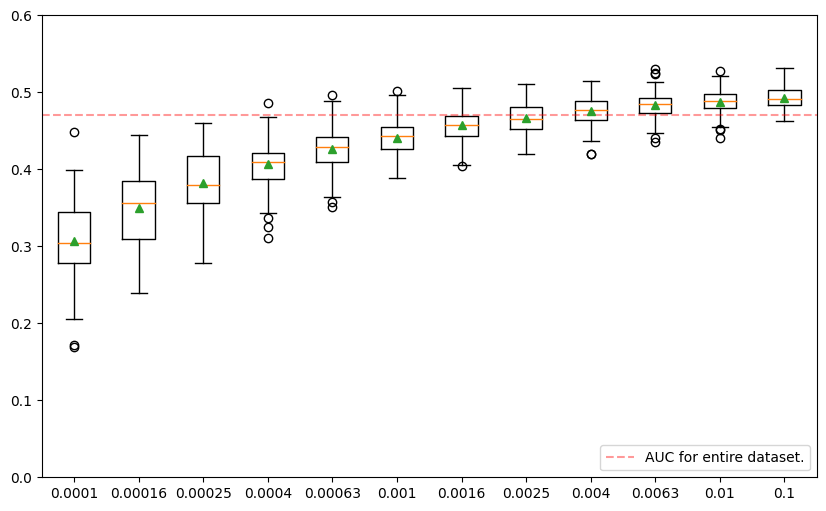

In [72]:
boxplot_data = [compiled_metrics[sub]["auc_first_gen"] for sub in subsample_proportions]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, showmeans=True)

plt.hlines(y=0.471, xmin=0.5, xmax=12.5, alpha = 0.4, colors='r', linestyles='dashed', label="AUC for entire dataset.")

# Add 1 to the x-coordinates of the points in the line plot
x_values_lineplot = np.arange(1, len(boxplot_data) + 1)

# Set the x-axis labels
plt.xticks(x_values_lineplot, subsample_proportions)

plt.xlim(0.5, 12.5)
plt.ylim(0, 0.6)
plt.legend(loc="lower right")
plt.show()

### Ensemble performance

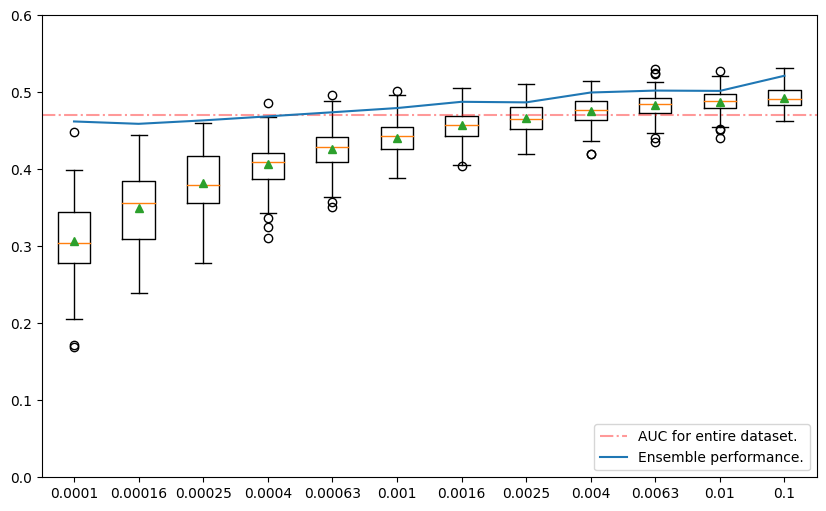

In [75]:
boxplot_data = [compiled_metrics[sub]["auc_first_gen"] for sub in subsample_proportions]
lineplot_data = [evaluate_ranking(*get_ensemble_metrics(get_files_list(sub, "results/random_forest_optimization/")))["auc_first_gen"] for sub in subsample_proportions]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, showmeans=True)

plt.hlines(y=0.471, xmin=0.5, xmax=12.5, alpha = 0.4, colors='r', linestyles='-.', label="AUC for entire dataset.")

# Add 1 to the x-coordinates of the points in the line plot
x_values_lineplot = np.arange(1, len(lineplot_data) + 1)
plt.plot(x_values_lineplot, lineplot_data, label=f"Ensemble performance.")

# Set the x-axis labels
plt.xticks(x_values_lineplot, subsample_proportions)

plt.xlim(0.5, 12.5)
plt.ylim(0, 0.6)
plt.legend(loc="lower right")
plt.show()

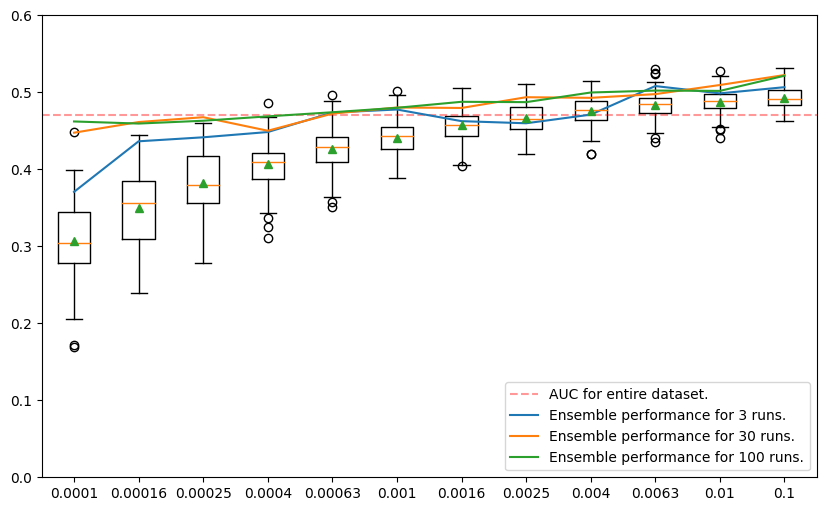

In [83]:
import random

boxplot_data = [compiled_metrics[sub]["auc_first_gen"] for sub in subsample_proportions]
lineplot_data = [evaluate_ranking(*get_ensemble_metrics(get_files_list(sub, "results/random_forest_optimization/")))["auc_first_gen"] for sub in subsample_proportions]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, showmeans=True)

plt.hlines(y=0.471, xmin=0.5, xmax=12.5, alpha = 0.4, colors='r', linestyles='dashed', label="AUC for entire dataset.")

# Add 1 to the x-coordinates of the points in the line plot
x_values_lineplot = np.arange(1, len(lineplot_data) + 1)
for n in [3, 25, 100]:
    random.seed(0)
    lineplot_data = [evaluate_ranking(*get_ensemble_metrics(random.sample(get_files_list(sub, "results/random_forest_optimization/"), n)))["auc_first_gen"] for sub in subsample_proportions]
    plt.plot(x_values_lineplot, lineplot_data, label=f"Ensemble performance for {n} runs.") 

# Set the x-axis labels
plt.xticks(x_values_lineplot, subsample_proportions)

plt.xlim(0.5, 12.5)
plt.ylim(0, 0.6)
plt.legend(loc="lower right")
plt.show()

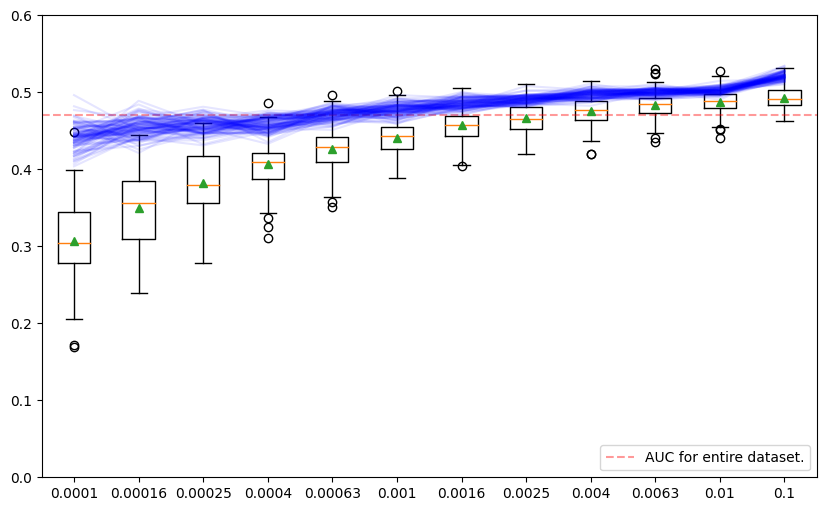

In [90]:
import random

boxplot_data = [compiled_metrics[sub]["auc_first_gen"] for sub in subsample_proportions]
lineplot_data = [evaluate_ranking(*get_ensemble_metrics(get_files_list(sub, "results/random_forest_optimization/")))["auc_first_gen"] for sub in subsample_proportions]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, showmeans=True)

plt.hlines(y=0.471, xmin=0.5, xmax=12.5, alpha = 0.4, colors='r', linestyles='dashed', label="AUC for entire dataset.")

# Add 1 to the x-coordinates of the points in the line plot
x_values_lineplot = np.arange(1, len(lineplot_data) + 1)
for i in range(100):
    random.seed(i**2)
    lineplot_data = [evaluate_ranking(*get_ensemble_metrics(random.sample(get_files_list(sub, "results/random_forest_optimization/"), 25)))["auc_first_gen"] for sub in subsample_proportions]
    plt.plot(x_values_lineplot, lineplot_data, alpha=0.1, color="blue") 

# Set the x-axis labels
plt.xticks(x_values_lineplot, subsample_proportions)

plt.xlim(0.5, 12.5)
plt.ylim(0, 0.6)
plt.legend(loc="lower right")
plt.show()

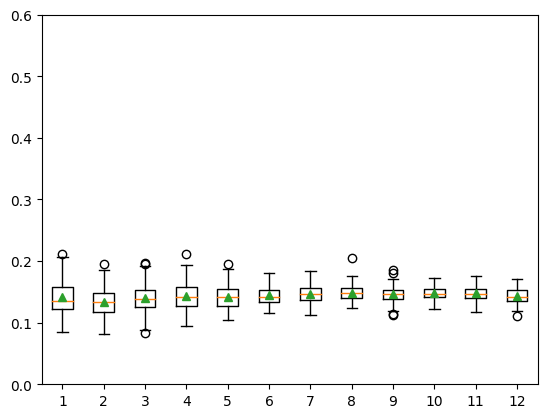

In [ ]:
plt.boxplot([compiled_metrics[sub]["auc_singles"] for sub in subsample_proportions], showmeans=True)
plt.ylim(0, 0.6)
plt.show()

## Jaccard score plots best/worst case scenario with uncertainty

In [41]:
directory = "results/random_forest_optimization/"
hash = 'all'

file_lists = get_file_lists(subsample_proportions, directory, hash)

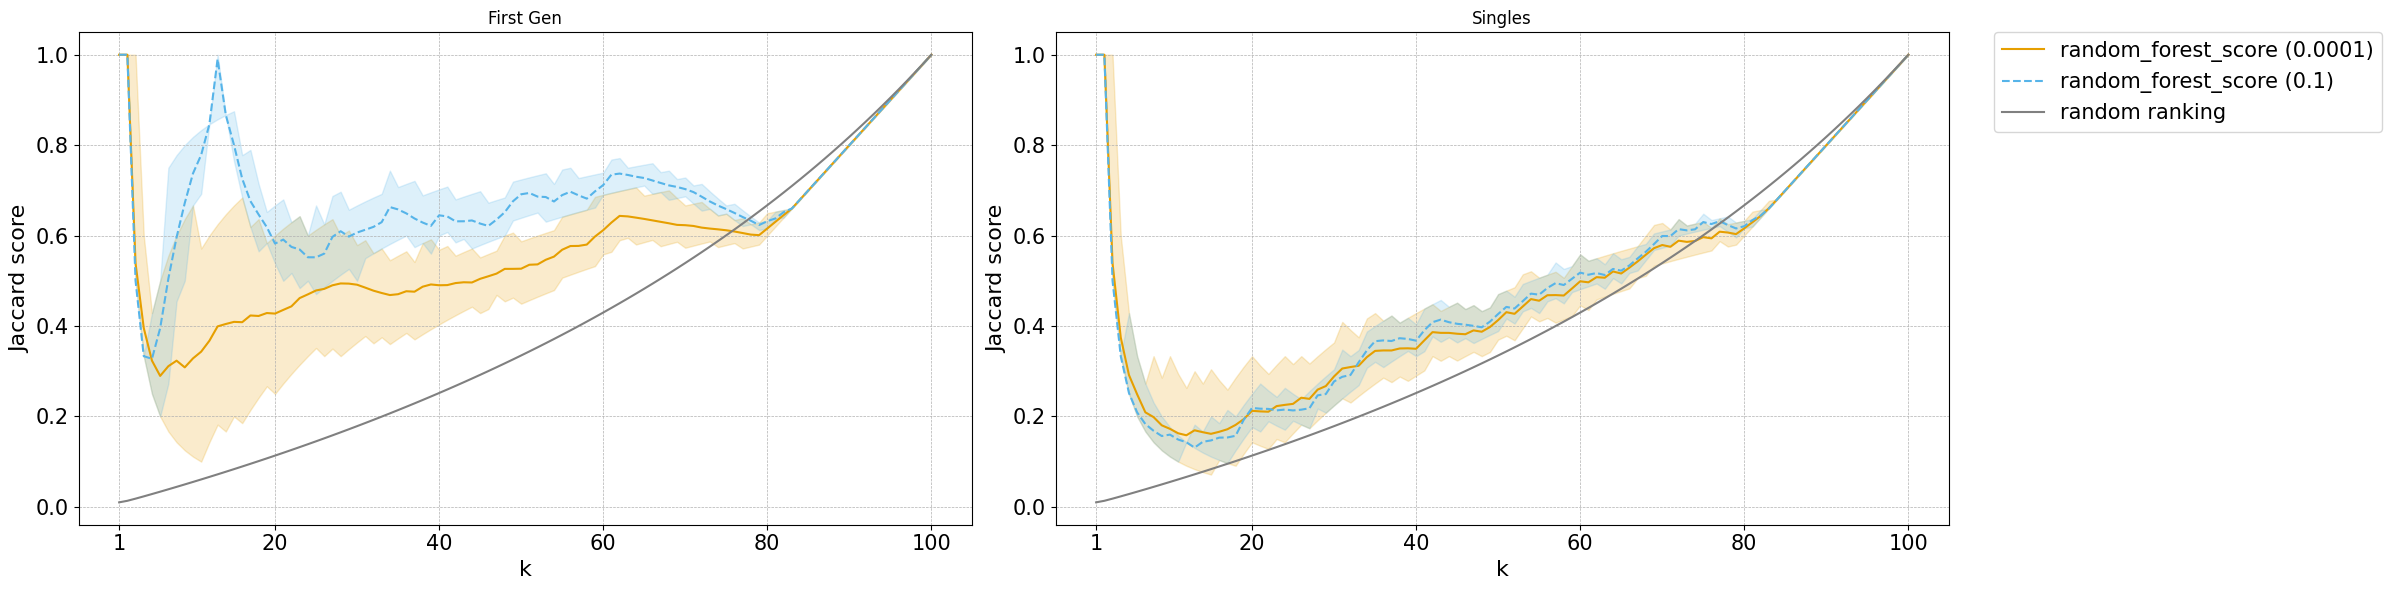

In [42]:
subs_to_plot = [0.0001, 0.1]
hf.plot_ranking_results([file_lists[sub] for sub in subs_to_plot])

### With feature selection

In [43]:
directory = "results/random_forest_selected_features/"
hash = "77ee7ce5"

file_lists = get_file_lists(subsample_proportions, directory, hash)

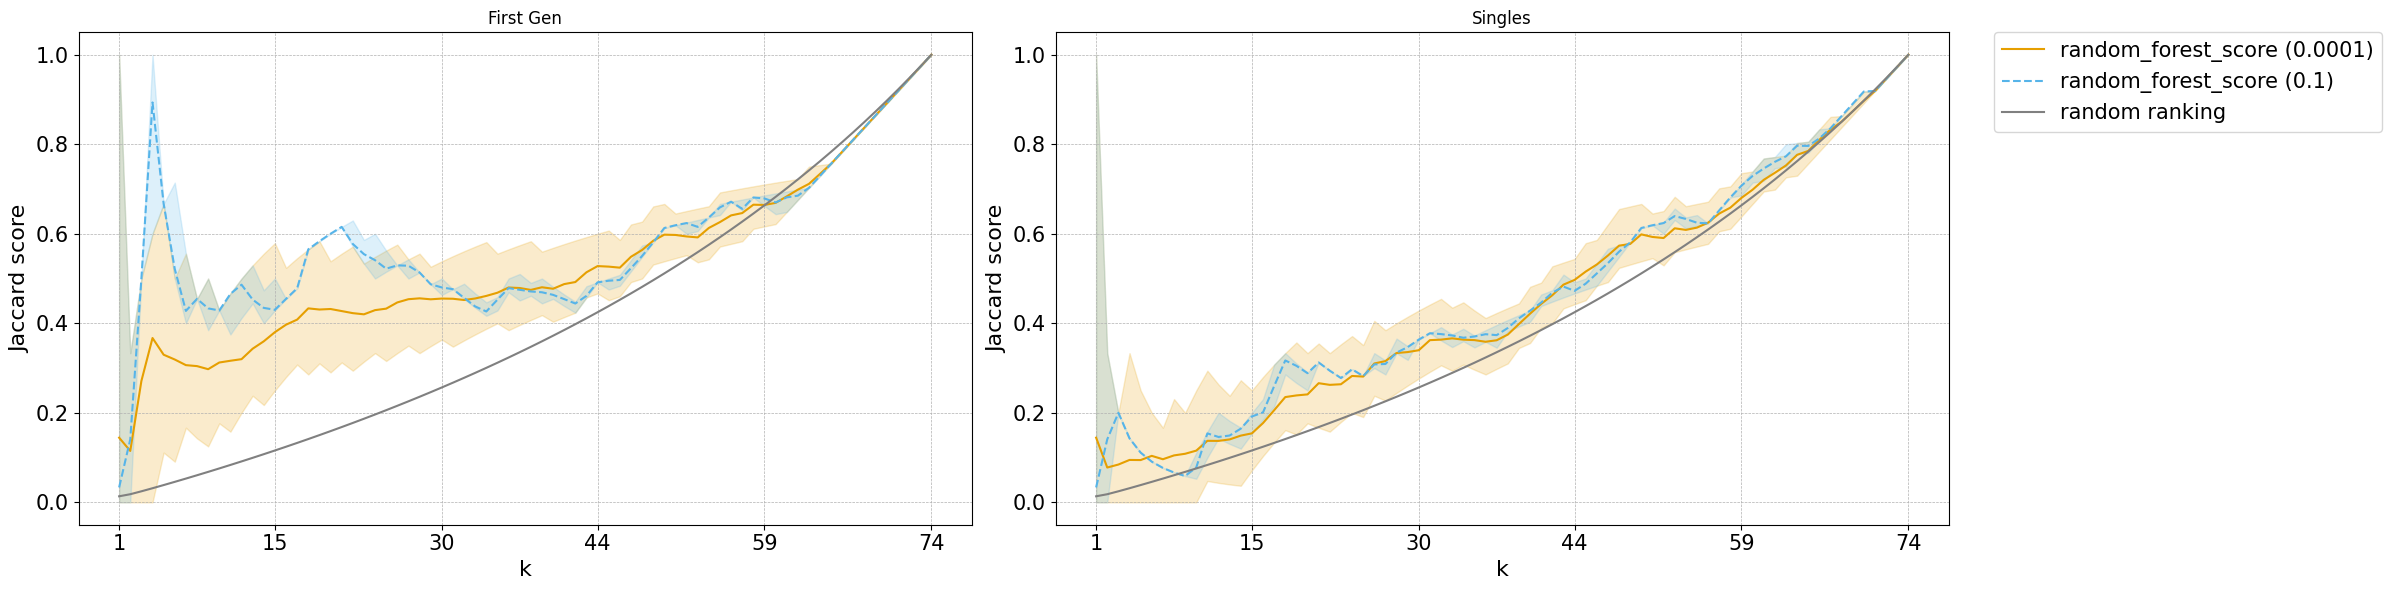

In [44]:
subs_to_plot = [0.0001, 0.1]
hf.plot_ranking_results([file_lists[sub] for sub in subs_to_plot])

## Prototype plots for logarithmic x axis

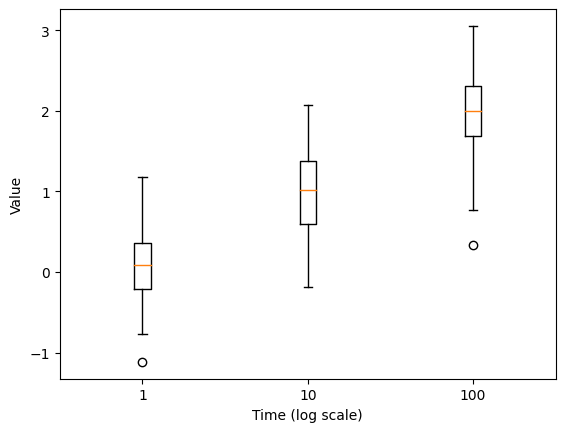

In [36]:
# Let's say we have three populations occurring at three different times
times = [1, 10, 100]
populations = [np.random.normal(loc=np.log10(i), scale=0.5, size=100) for i in times]

fig, ax = plt.subplots()

# Space boxplots evenly on a linear scale
linear_positions = range(1, len(times)+1)

for i, (time, population) in enumerate(zip(linear_positions, populations)):
    ax.boxplot(population, positions=[time], widths=0.1)

# Set x-axis labels to represent log scale
ax.set_xticks(linear_positions)
ax.set_xticklabels(times)

ax.set_xlabel('Time (log scale)')
ax.set_ylabel('Value')
plt.show()


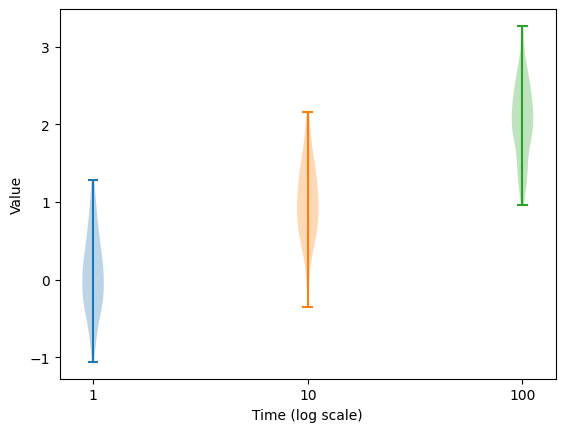

In [37]:
# Let's say we have three populations occurring at three different times
times = [1, 10, 100]
populations = [np.random.normal(loc=np.log10(i), scale=0.5, size=100) for i in times]

fig, ax = plt.subplots()

# Space violin plots evenly on a linear scale
linear_positions = range(1, len(times)+1)

for i, (time, population) in enumerate(zip(linear_positions, populations)):
    ax.violinplot(population, positions=[time], widths=0.1)

# Set x-axis labels to represent log scale
ax.set_xticks(linear_positions)
ax.set_xticklabels(times)

ax.set_xlabel('Time (log scale)')
ax.set_ylabel('Value')
plt.show()
